In [8]:
# Import lobraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    roc_curve,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap


In [9]:
# Load Dataset
df = pd.read_csv(r"C:\Users\Muhammad Ali\Desktop\Devs Hub\bank-full.csv", sep=';')


print(df.shape)
df.head()


(45210, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,durations,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
#  Explore Dataset
df.info()
df['y'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45210 entries, 0 to 45209
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45210 non-null  int64 
 1   job        45210 non-null  object
 2   marital    45210 non-null  object
 3   education  45210 non-null  object
 4   default    45210 non-null  object
 5   balance    45210 non-null  int64 
 6   housing    45210 non-null  object
 7   loan       45210 non-null  object
 8   contact    45210 non-null  object
 9   day        45210 non-null  int64 
 10  month      45210 non-null  object
 11  durations  45210 non-null  int64 
 12  campaign   45210 non-null  int64 
 13  pdays      45210 non-null  int64 
 14  previous   45210 non-null  int64 
 15  poutcome   45210 non-null  object
 16  y          45210 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


y
no     39921
yes     5289
Name: count, dtype: int64

In [11]:
# Separate Features + Target

X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})


In [12]:
# Encode Categorical Features
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)


In [13]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [20]:
# Build Models
# Logistic Regression pipeline
log_model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(
        solver='saga',
        max_iter=3000
    ))
])
log_model.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
# Random Forest pipeline

rf_model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
# Evaluation Function

def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"===== {name} =====")
    print(classification_report(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9981
           1       0.54      0.09      0.16      1322

    accuracy                           0.88     11303
   macro avg       0.71      0.54      0.55     11303
weighted avg       0.85      0.88      0.85     11303

F1 Score: 0.1553398058252427
Confusion Matrix:
 [[9878  103]
 [1202  120]]


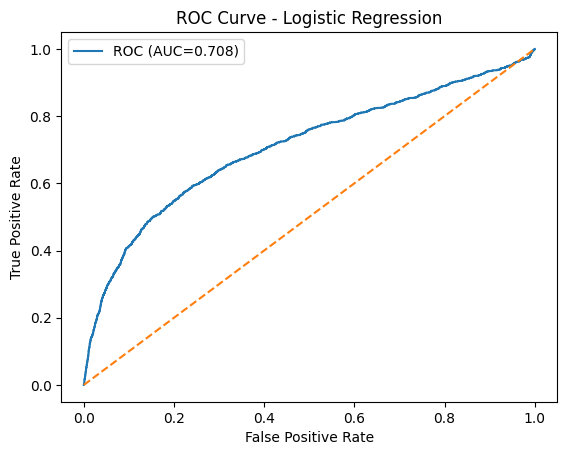

In [23]:
# Run evaluations(LR)
evaluate_model(log_model, "Logistic Regression")


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      9981
           1       0.66      0.42      0.51      1322

    accuracy                           0.91     11303
   macro avg       0.79      0.69      0.73     11303
weighted avg       0.89      0.91      0.90     11303

F1 Score: 0.5094951366373321
Confusion Matrix:
 [[9694  287]
 [ 772  550]]


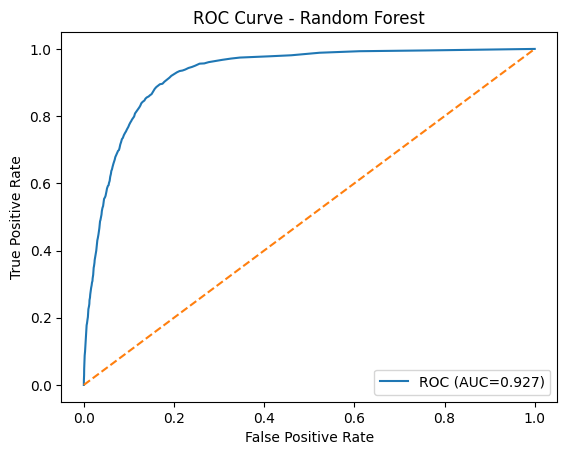

In [24]:
# Run evaluations(RF)
evaluate_model(rf_model, "Random Forest")


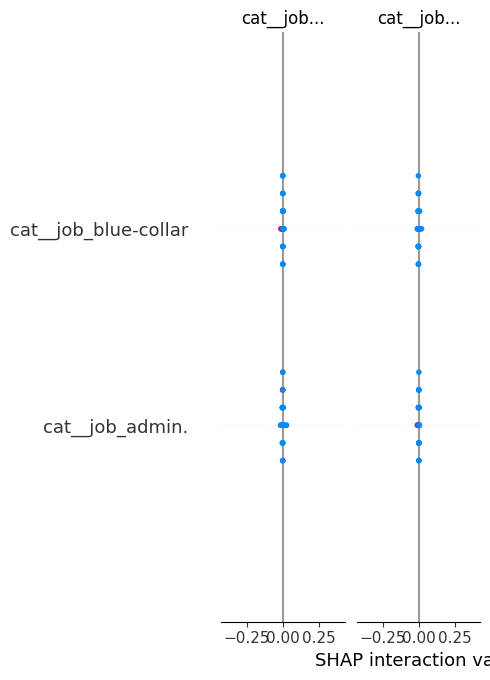

In [28]:
# SHAP Summary Plot

sample = X_train_encoded[:50]   # or 200 if your PC is fast enough

shap_values = explainer(sample)

shap.summary_plot(
    shap_values,
    features=sample,
    feature_names=prep.get_feature_names_out()
)


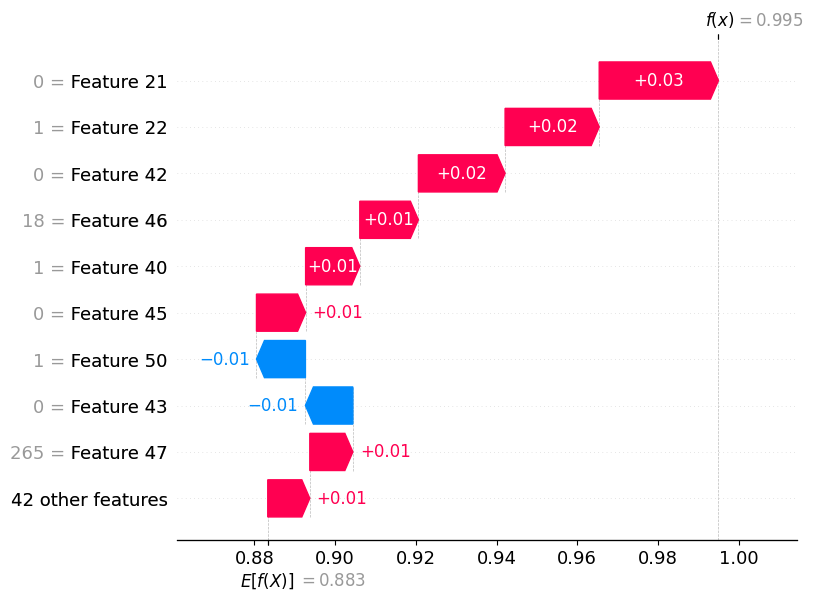

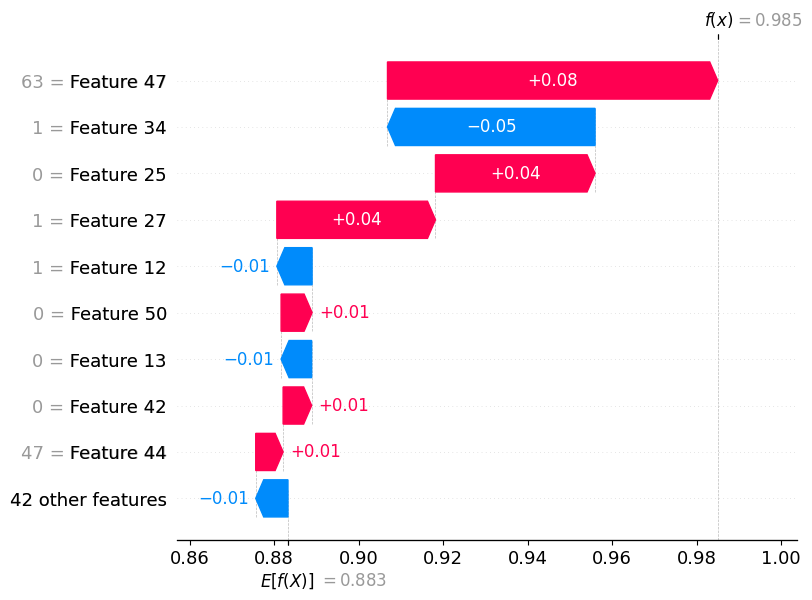

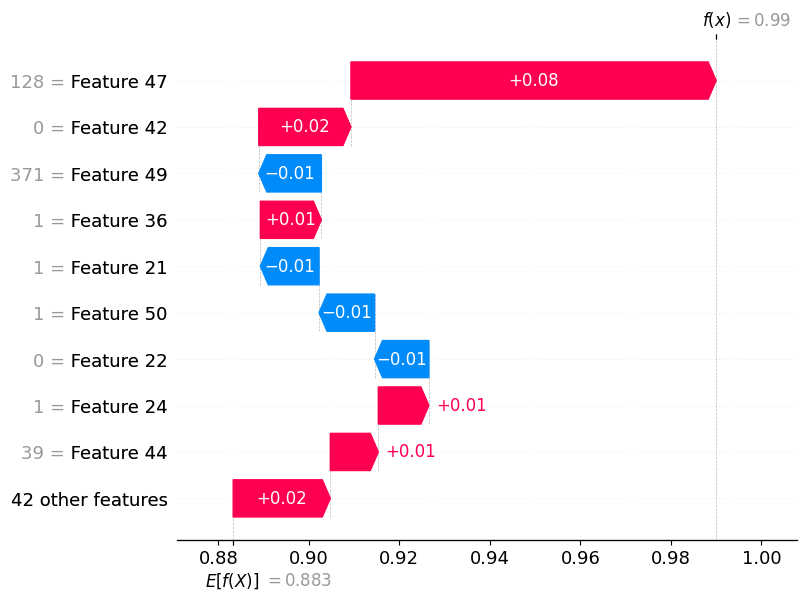

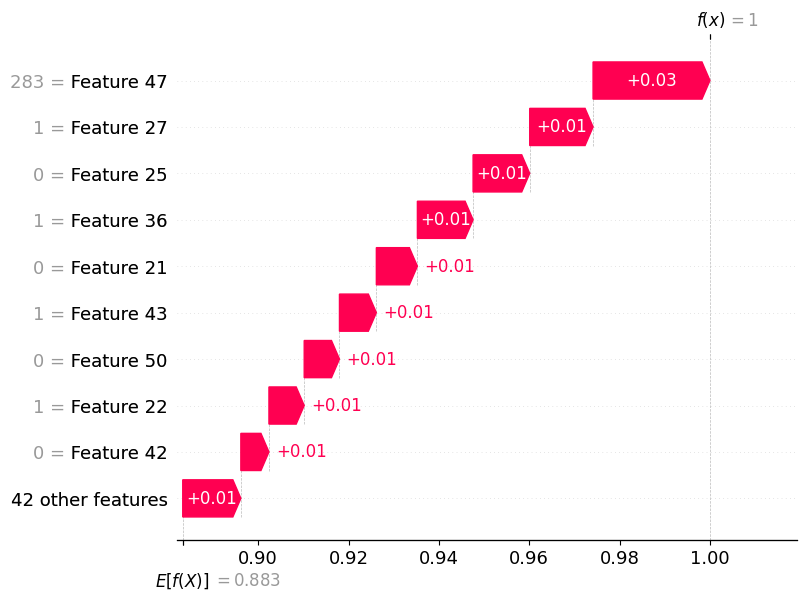

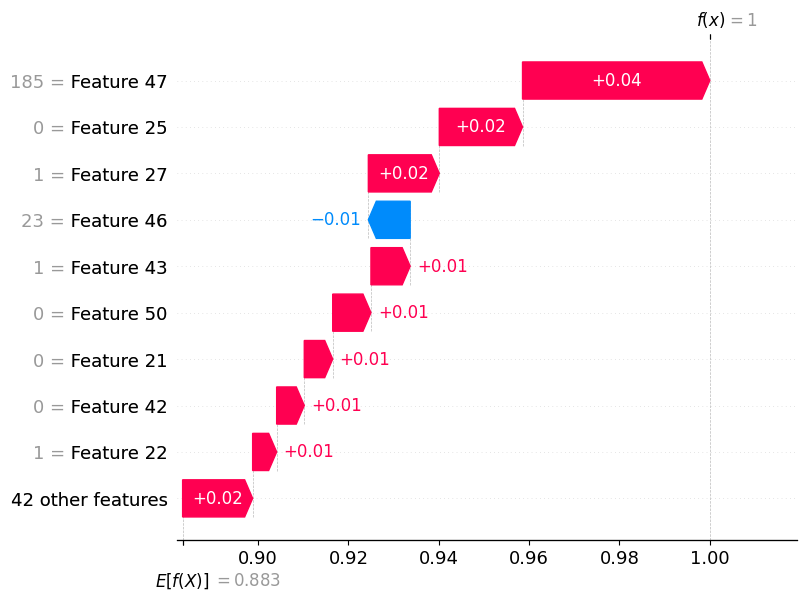

In [37]:
# SHAP Waterfall Plot



for i in range(5):
    single_exp = shap.Explanation(
        values=shap_values5.values[i, :, 0],        # shap values for sample i, output 0
        base_values=shap_values5.base_values[i, 0], # base value for sample i, output 0
        data=shap_values5.data[i],
        feature_names=shap_values5.feature_names
    )
    shap.plots.waterfall(single_exp)
